#**Handson on Domain Decomposition Technique**

**Advanced Methods For Scientific Computing,**

Prof. Luca Formaggia, Dr. Paolo Joseph Baioni

Polimi, Nov 2025

**[GitHub Repo](https://github.com/AMSC-25-26/dd-02-dd)**

##Team 2-DD Members:

- Alessandro Russi
- Francesca Marina Pozzi
- Martina Rusconi
- Micaela Perlini
- Seyed Vahid Ghayoomie


# What do you have to do

For the hands-on, you should:
- implement a class to solve the problem (1). Note that you have a tridiagonal system so you can use the Thomas algorithm given in the Example. But you may choose instead to rely on the Eigen library.
- implement the Schwarz iterator as a solver, with a class that is composed.
- implement the parallel version in MPI or OpenMP.
- have a way to show the results (choose the graphic library or tool you prefer).

#**Solution**

In [1]:
!git clone https://github.com/AMSC-25-26/dd-02-dd
%cd dd-02-dd

Cloning into 'dd-02-dd'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 398 (delta 66), reused 33 (delta 12), pack-reused 273 (from 3)
Receiving objects: 100% (398/398), 1.11 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (238/238), done.
/content/dd-02-dd


In [2]:
%cd src

/content/dd-02-dd/src


In [ ]:
!make all

## Thomas and Schwarz Solvers

We are trying to solve the 1D elliptic boundary value problem

$$
\begin{aligned}
-\mu u''(x) + cu(x) = f(x), \qquad x \in (a,b),\\
\quad u(a)=u_a, \quad u(b)=u_b,
\end{aligned}
$$

using **finite difference discretization** and **domain decomposition methods**, following the course notes (`dd.pdf`).

The same discrete problem is solved using four complementary approaches:

1. **Thomas Algorithm (Sequential)**  
   - Direct solver for tridiagonal systems  
   - Serves as the baseline reference solution  

2. **Additive Schwarz Domain Decomposition**  
   - Overlapping subdomains  
   - Parallel implementation using OpenMP and MPI  
   - Iterative solver validated against the direct solution  

3. **Eigen Sparse Direct Solver**  
   - Finite difference discretization assembled into a sparse matrix  
   - Solved using Eigen’s sparse Cholesky factorization  
   - Provides an independent algebraic reference (non-FEM)  

4. **Exact Analytical Solution (Verification Benchmark)**  

   For simplicity, the continuous problem reads

$$
   \begin{aligned}
   -\mu u''(x) + c u(x) = f(x), \qquad x \in (0,L), \\
   u(0) = 0, \qquad u(L) = 0 .
   \end{aligned}
$$

   Closed-form solutions are available for the following right-hand sides.

   **Case 1: $f(x) = \sin(2 \pi x)$**

$$
   \begin{aligned}
   u(x) &= \frac{1}{4 \mu \pi^2 + c} \sin(2 \pi x) .
   \end{aligned}
$$

   **Case 2: $f(x) = 1$**

   For $c > 0$:

$$
   \begin{aligned}
   u(x)
   &=
   \frac{1}{c}
   \left[
   1 -
   \frac{\cosh \left(\sqrt{\frac{c}{\mu}}\left(x-\frac{L}{2}\right)\right)}
        {\cosh \left(\sqrt{\frac{c}{\mu}}\frac{L}{2}\right)}
   \right] .
   \end{aligned}
$$

   In the limiting Poisson case $c=0$:

$$
   \begin{aligned}
   u(x) &= \frac{x(L-x)}{2\mu} .
   \end{aligned}
$$

   These exact solutions are used as verification benchmarks to assess discretization errors and validate the convergence of the numerical solvers.

### **$Case 1: f(x) = \sin(2 \pi x)$**

In [4]:
#!make run_seq

In [22]:
!pwd

/content/dd-02-dd/src


In [23]:
# add --allow-run-as-root and use -np 1 if you are running the file in a free Google Colab env
!export OMP_NUM_THREADS=2
# !mpirun --allow-run-as-root -np 1 ../build/schwarz_mpi 200 4 0.01 5.0 0.0 1.0 0.0 0.0 2000 1e-6 2 1
!mpirun -np 2 ../build/schwarz_mpi 200 4 0.01 5.0 0.0 1.0 0.0 0.0 2000 1e-6 2 1


###############################################
  RUNNING SEQUENTIAL SOLVER  
###############################################

  SEQUENTIAL SOLVER COMPLETED
Sequential solution saved to 'sequential_solution.csv'


###############################################
  RUNNING PARALLEL SCHWARZ SOLVER
###############################################

  SCHWARZ METHOD CONFIGURATION
Diffusion coefficient:     0.01
Reaction coefficient:      5
Global nodes:              200
Mesh size h:               0.00502513
MPI processes:             1
Overlap size:              4 nodes
Tolerance:                 1e-06
Max iterations:            2000
Iteration    0 | Error = 1.849014e+00
  CONVERGED in 2 iterations
  Final error: 0.000000e+00

Solution saved to 'parallel_solution.csv'

###############################################
  PERFORMANCE COMPARISON  
###############################################
Relative L2 error:         1.700778e-06


In [24]:
!head -n 10 sequential_solution.csv

x,u_s
0,0
0.00502513,0.00585172
0.0100503,0.0116976
0.0150754,0.0175318
0.0201005,0.0233486
0.0251256,0.029142
0.0301508,0.0349065
0.0351759,0.0406361
0.040201,0.0463252


In [25]:
!head -n 10 parallel_solution.csv

x,u_p
0,0
0.00502513,0.00585172
0.0100503,0.0116976
0.0150754,0.0175318
0.0201005,0.0233486
0.0251256,0.029142
0.0301508,0.0349065
0.0351759,0.0406361
0.040201,0.0463252


#### Eigen Solver

In [ ]:
!sudo apt update
!sudo apt install libeigen3-dev

In [9]:
%%writefile eigen_solver.cpp

#include <iostream>
#include <fstream>
#include <Eigen/Sparse>
#include <Eigen/SparseCholesky>

std::vector<double> eigen_solve(
    int N, double L, double mu, double c,
    const std::vector<double>& f)
{
    double h = L / (N + 1);

    Eigen::SparseMatrix<double> A(N, N);
    std::vector<Eigen::Triplet<double>> triplets;

    double diag = 2.0 * mu / (h*h) + c;
    double off  = -mu / (h*h);

    for (int i = 0; i < N; i++) {
        triplets.emplace_back(i, i, diag);
        if (i > 0)   triplets.emplace_back(i, i-1, off);
        if (i < N-1) triplets.emplace_back(i, i+1, off);
    }

    A.setFromTriplets(triplets.begin(), triplets.end());

    Eigen::VectorXd rhs(N);
    for (int i = 0; i < N; i++)
        rhs[i] = f[i];

    Eigen::SimplicialLLT<Eigen::SparseMatrix<double>> solver;
    solver.compute(A);

    Eigen::VectorXd u = solver.solve(rhs);

    std::vector<double> result(N);
    for (int i = 0; i < N; i++)
        result[i] = u[i];

    return result;
}


Writing eigen_solver.cpp


In [10]:
%%writefile test_eigen_solver.cpp

#include "eigen_solver.cpp"

void save(const std::string& name, const std::vector<double>& v) {
    std::ofstream out(name);
    for (auto x : v) out << x << "\n";
}

int main() {
    int N = 200;  // number of interior points
    double L = 1.0;
    double mu = 0.01;
    double c  = 5.0;
    double h = L/(N+1);

    // Build f(x) = sin(pi x)
    std::vector<double> f(N);
    for (int i = 0; i < N; i++) {
        double x = (i+1)*h;
        f[i] = std::sin(2 * M_PI * x);
    }

    auto u_eigen = eigen_solve(N, L, mu, c, f);
    save("u_eigen.txt", u_eigen);

    std::cout << "Files written: u_eigen.txt\n";
}

Writing test_eigen_solver.cpp


In [11]:
!g++ test_eigen_solver.cpp -I/usr/include/eigen3 -o test_eigen_solver

In [12]:
!./test_eigen_solver

Files written: u_eigen.txt


In [13]:
!head -n 10 u_eigen.txt

0.00579351
0.0115814
0.0173579
0.0231175
0.0288544
0.0345632
0.0402382
0.045874
0.0514648
0.0570054


#### Exact Solution

The exact solution for the equation in case $f(x)=sin(2 \pi x)$:

\begin{equation}
\boxed{
u(x)
=
\frac{1}{4 \mu \pi^2 + c}\,\sin(2 \pi x)
}
\end{equation}

In [ ]:
%pip install sympy matplotlib

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Exact solution with BCs (LaTeX):


<IPython.core.display.Math object>

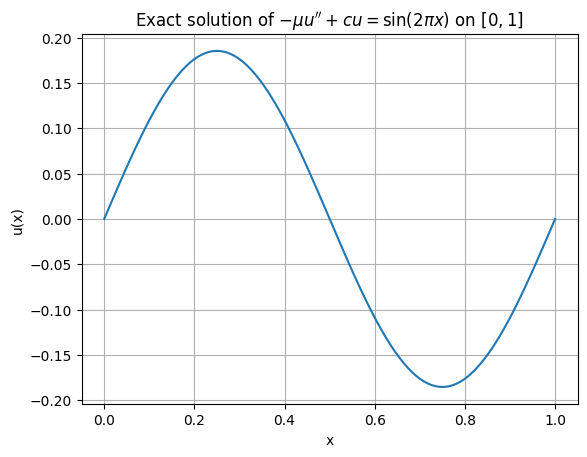

In [15]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

# -----------------------------
# Symbolic definition
# -----------------------------
x = sp.symbols('x')
mu, c = sp.symbols('mu c', positive=True)

u = sp.Function('u')

# RHS
f = sp.sin(2 * sp.pi * x)

# ODE: -mu u'' + c u = sin(2πx)
eq = -mu*sp.diff(u(x), x, 2) + c*u(x) - f

# General solution
sol = sp.dsolve(eq)

# Display general solution in LaTeX
display(Math(r"\text{General solution:}"))
display(Math(sp.latex(sol)))

# -----------------------------
# Impose BCs: u(0)=u(1)=0
# -----------------------------
u_general = sol.rhs
C1, C2 = sp.symbols('C1 C2')

bc_eqs = [
    u_general.subs(x, 0),
    u_general.subs(x, 1)
]

constants = sp.solve(bc_eqs, (C1, C2))
u_exact = sp.simplify(u_general.subs(constants))

# Print exact solution in LaTeX
latex_exact = sp.latex(u_exact)
print("\nExact solution with BCs (LaTeX):")
display(Math(latex_exact))

# Write LaTeX to file
with open("u_exact.tex", "w") as f:
    f.write(r"\[" + "\n")
    f.write(latex_exact + "\n")
    f.write(r"\]" + "\n")

# -----------------------------
# Numerical evaluation on [0,1]
# -----------------------------
u_num = sp.lambdify(
    x,
    u_exact.subs({mu: 0.01, c: 5.0}),
    "numpy"
)

x_vals = np.linspace(0.0, 1.0, 200)
u_vals = u_num(x_vals)

# Write numerical solution to file
with open("u_exact.txt", "w") as f:
    for xi, ui in zip(x_vals, u_vals):
        f.write(f"{ui:.12e}\n")

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(x_vals, u_vals)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r"Exact solution of $-\mu u'' + c u = \sin(2 \pi x)$ on $[0,1]$")
plt.grid(True)
plt.show()


#### Thomas vs Schwarz vs  Eigen vs Exact Solution

Relative L2 error = 6.294315005084584e-06


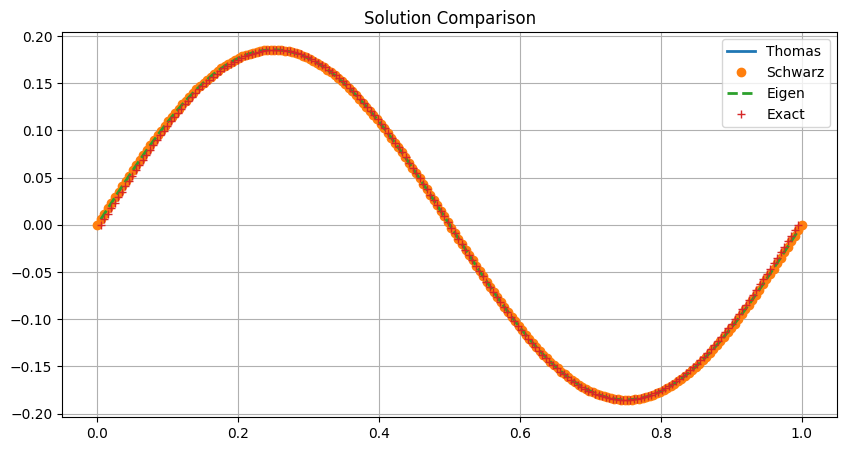

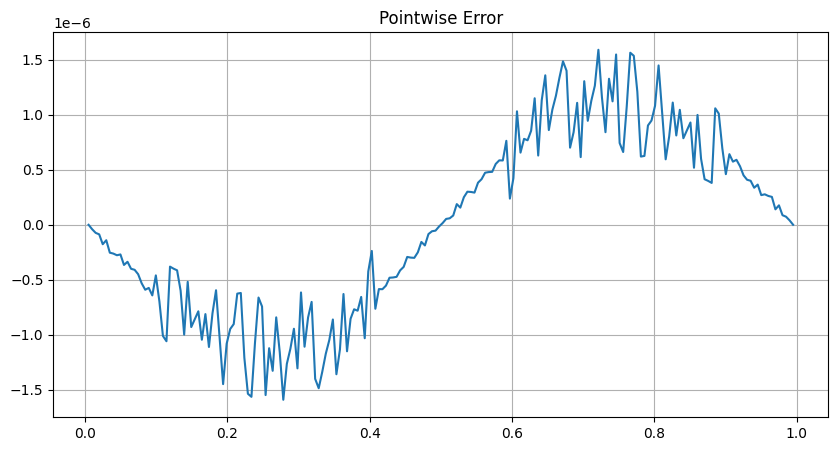

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os

thomas_solution_path = "sequential_solution.csv"
eigen_solution_path = "u_eigen.txt"
exact_solution_path = "u_exact.txt"

data_thomas = np.loadtxt(thomas_solution_path, delimiter=',', skiprows=1)
u_t = data_thomas.T[1]
x_t = data_thomas.T[0]

schwarz_solution_path = "parallel_solution.csv"
data_schwarz = np.loadtxt(schwarz_solution_path, delimiter=',', skiprows=1)
u_s = data_schwarz.T[1]
x_s = data_schwarz.T[0]

u_ei = np.loadtxt(eigen_solution_path)
u_ex = np.loadtxt(exact_solution_path)
x = np.linspace(0,1,len(u_t)+2)[1:-1]

# Compute error
err = u_ex - u_t
L2 = np.linalg.norm(err) / np.linalg.norm(u_ex)

print("Relative L2 error =", L2)

plt.figure(figsize=(10,5))
plt.plot(x_t, u_t, label="Thomas", linewidth=2)
plt.plot(x_s, u_s, 'o', label="Schwarz", linewidth=2)
plt.plot(x, u_ei, '--', label="Eigen", linewidth=2)
plt.plot(x, u_ex, '+', label="Exact", linewidth=2)
plt.title("Solution Comparison")
plt.legend()
plt.grid()

plt.figure(figsize=(10,5))
plt.plot(x, err, label="Error (Exact - Thomas)")
plt.title("Pointwise Error")
plt.grid()

plt.show()

---

### **$Case 2: f(x) = 1$**

For $c > 0$:

$$
   \begin{aligned}
   u(x)
   &=
   \frac{1}{c}
   \left[
   1 -
   \frac{\cosh \left(\sqrt{\frac{c}{\mu}}\left(x-\frac{L}{2}\right)\right)}
        {\cosh \left(\sqrt{\frac{c}{\mu}}\frac{L}{2}\right)}
   \right] .
   \end{aligned}
$$

In [28]:
# add --allow-run-as-root and use -np 1 if you are running the file in a free Google Colab env
!export OMP_NUM_THREADS=2
# !mpirun --allow-run-as-root -np 1 ../build/schwarz_mpi 200 4 0.01 5.0 0.0 1.0 0.0 0.0 2000 1e-6 1 1
!mpirun -np 2 ../build/schwarz_mpi 200 4 0.01 5.0 0.0 1.0 0.0 0.0 2000 1e-6 1 1


###############################################
  RUNNING SEQUENTIAL SOLVER  
###############################################

  SEQUENTIAL SOLVER COMPLETED
Sequential solution saved to 'sequential_solution.csv'


###############################################
  RUNNING PARALLEL SCHWARZ SOLVER
###############################################

  SCHWARZ METHOD CONFIGURATION
Diffusion coefficient:     0.01
Reaction coefficient:      5
Global nodes:              200
Mesh size h:               0.00502513
MPI processes:             1
Overlap size:              4 nodes
Tolerance:                 1e-06
Max iterations:            2000
Iteration    0 | Error = 2.625165e+00
  CONVERGED in 2 iterations
  Final error: 0.000000e+00

Solution saved to 'parallel_solution.csv'

###############################################
  PERFORMANCE COMPARISON  
###############################################
Relative L2 error:         1.418850e-06


#### Eigen Solver

In [29]:
%%writefile test_eigen_solver.cpp

#include "eigen_solver.cpp"

void save(const std::string& name, const std::vector<double>& v) {
    std::ofstream out(name);
    for (auto x : v) out << x << "\n";
}

int main() {
    int N = 200;  // number of interior points
    double L = 1.0;
    double mu = 0.01;
    double c  = 5.0;
    double h = L/(N+1);

    // Build f(x) = 1.0
    std::vector<double> f(N);
    for (int i = 0; i < N; i++) {
        double x = (i+1)*h;
        f[i] = 1.0;
    }

    auto u_eigen = eigen_solve(N, L, mu, c, f);
    save("u_eigen.txt", u_eigen);

    std::cout << "Files written: u_eigen.txt\n";
}

Overwriting test_eigen_solver.cpp


In [30]:
!g++ test_eigen_solver.cpp -I/usr/include/eigen3 -o test_eigen_solver

In [31]:
!./test_eigen_solver

Files written: u_eigen.txt


#### Exact Solution

The exact solution for the equation in case $f(x) = 1.0$:

\begin{equation}
\boxed{
u(x)
=
\frac{1}{c}
\left[
1
-
\frac{\cosh\!\left(\lambda\left(x-\tfrac{L}{2}\right)\right)}
     {\cosh\!\left(\lambda\tfrac{L}{2}\right)}
\right]
, \qquad \lambda = \sqrt{\frac{c}{\mu}}
}
\end{equation}

General solution (LaTeX):


<IPython.core.display.Math object>


Exact solution with BCs (LaTeX):


<IPython.core.display.Math object>

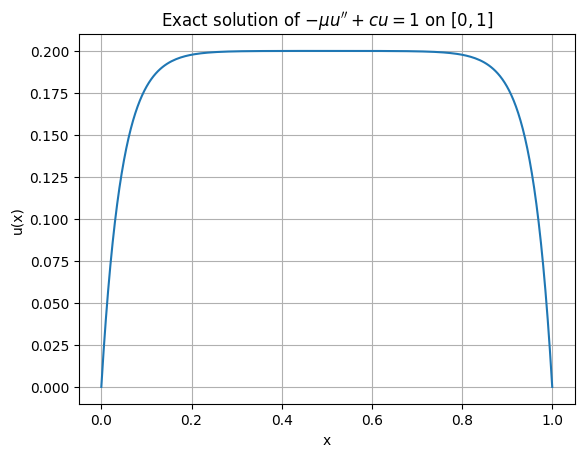

In [32]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

# -----------------------------
# Symbolic problem definition
# -----------------------------
x = sp.symbols('x')
mu, c = sp.symbols('mu c', positive=True)

u = sp.Function('u')

# PDE reduced to ODE
eq = -mu*sp.diff(u(x), x, 2) + c*u(x) - 1

# General symbolic solution
sol = sp.dsolve(eq)

# Print general solution in LaTeX
print("General solution (LaTeX):")
display(Math(sp.latex(sol)))

# -----------------------------
# Impose BCs: u(0)=u(1)=0
# -----------------------------
u_general = sol.rhs
C1, C2 = sp.symbols('C1 C2')

bc_eqs = [
    u_general.subs(x, 0),
    u_general.subs(x, 1)
]

constants = sp.solve(bc_eqs, (C1, C2))
u_exact = sp.simplify(u_general.subs(constants))

# Print exact solution in LaTeX
latex_exact = sp.latex(u_exact)
print("\nExact solution with BCs (LaTeX):")
display(Math(latex_exact))

# Write LaTeX to file
with open("u_exact.tex", "w") as f:
    f.write(r"\[" + "\n")
    f.write(latex_exact + "\n")
    f.write(r"\]" + "\n")

# -----------------------------
# Numerical evaluation on [0,1]
# -----------------------------
u_num = sp.lambdify(
    x,
    u_exact.subs({mu: 0.01, c: 5.0}),
    "numpy"
)

x_vals = np.linspace(0.0, 1.0, 200)
u_vals = u_num(x_vals)

# Write numerical solution to file
with open("u_exact.txt", "w") as f:
    for xi, ui in zip(x_vals, u_vals):
        f.write(f"{ui:.12e}\n")

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(x_vals, u_vals)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r"Exact solution of $-\mu u'' + c u = 1$ on $[0,1]$")
plt.grid(True)
plt.show()


#### Thomas vs Schwarz vs  Eigen vs Exact Solution

Relative L2 error = 8.466388287480638e-05


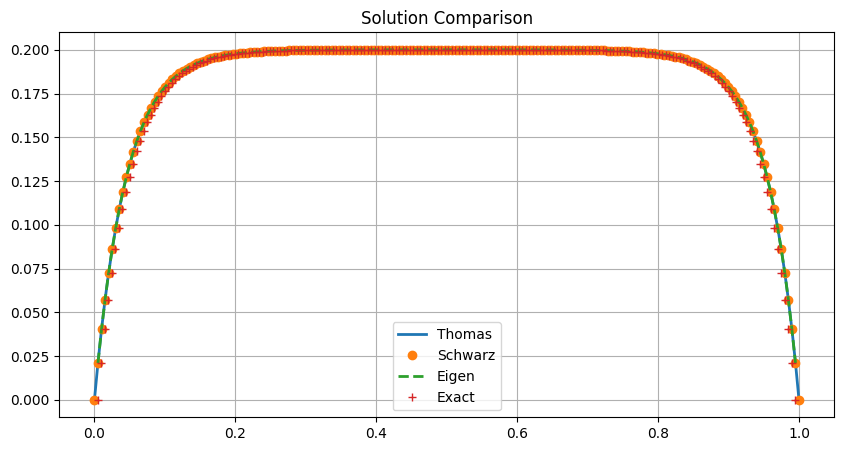

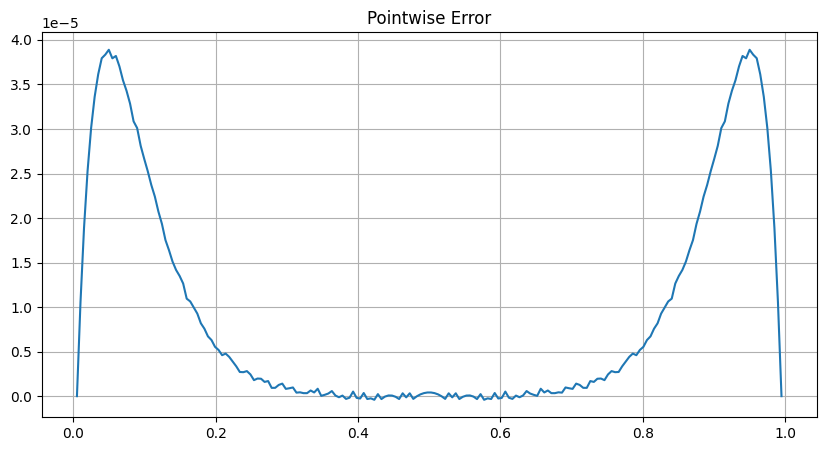

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os

thomas_solution_path = "sequential_solution.csv"
eigen_solution_path = "u_eigen.txt"
exact_solution_path = "u_exact.txt"

data_thomas = np.loadtxt(thomas_solution_path, delimiter=',', skiprows=1)
u_t = data_thomas.T[1]
x_t = data_thomas.T[0]

schwarz_solution_path = "parallel_solution.csv"
data_schwarz = np.loadtxt(schwarz_solution_path, delimiter=',', skiprows=1)
u_s = data_schwarz.T[1]
x_s = data_schwarz.T[0]

u_ei = np.loadtxt(eigen_solution_path)
u_ex = np.loadtxt(exact_solution_path)
x = np.linspace(0,1,len(u_t)+2)[1:-1]

# Compute error
err = u_ex - u_t
L2 = np.linalg.norm(err) / np.linalg.norm(u_ex)

print("Relative L2 error =", L2)

plt.figure(figsize=(10,5))
plt.plot(x_t, u_t, label="Thomas", linewidth=2)
plt.plot(x_s, u_s, 'o', label="Schwarz", linewidth=2)
plt.plot(x, u_ei, '--', label="Eigen", linewidth=2)
plt.plot(x, u_ex, '+', label="Exact", linewidth=2)
plt.title("Solution Comparison")
plt.legend()
plt.grid()

plt.figure(figsize=(10,5))
plt.plot(x, err, label="Error (Exact - Thomas)")
plt.title("Pointwise Error")
plt.grid()

plt.show()